converting .txt to csv from box

In [ ]:
import pandas as pd

# Load the TXT file (assuming space-separated values)
df = pd.read_csv("/content/83332.protein.physical.links.detailed.v12.0 (1).txt", sep="\s+", header=0)

# Save as CSV
df.to_csv("/content/your_file.csv", index=False)

print("Conversion complete! Saved as protein_file.csv")

Conversion complete! Saved as protein_file.csv


Load CSV and Preprocess Data
This ensures that the data is correctly loaded.
Confirm that columns (protein1, protein2, combined_score, etc.) are properly read.

In [ ]:
df = pd.read_csv(file_path, delimiter=r'[\t,]', engine='python')

In [ ]:
print(df.head())

       protein1       protein2  experimental  database  textmining  \
0  83332.Rv0001  83332.Rv2343c             0         0         316   
1  83332.Rv0001   83332.Rv0639             0         0         174   
2  83332.Rv0001  83332.Rv3427c           178         0         124   
3  83332.Rv0001  83332.Rv3923c             0         0         522   
4  83332.Rv0001  83332.Rv3213c           237         0         315   

   combined_score  
0             315  
1             173  
2             249  
3             522  
4             455  


Convert this DataFrame into a Graph using NetworkX where:
Nodes = Unique protein IDs
Edges = (protein1, protein2) pairs
Weights = combined_score

In [ ]:
import networkx as nx

# Create an empty graph
G = nx.Graph()

# Add edges with weights
for index, row in df.iterrows():
    protein1 = row["protein1"]
    protein2 = row["protein2"]
    weight = row["combined_score"]

    G.add_edge(protein1, protein2, weight=weight)

# Print basic graph info
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 2464
Number of edges: 37467


protein-protein interaction graph has been successfully created with:

2,464 proteins (nodes)
37,467 interactions (edges)

let's plot a small subset of the graph to check its structure.

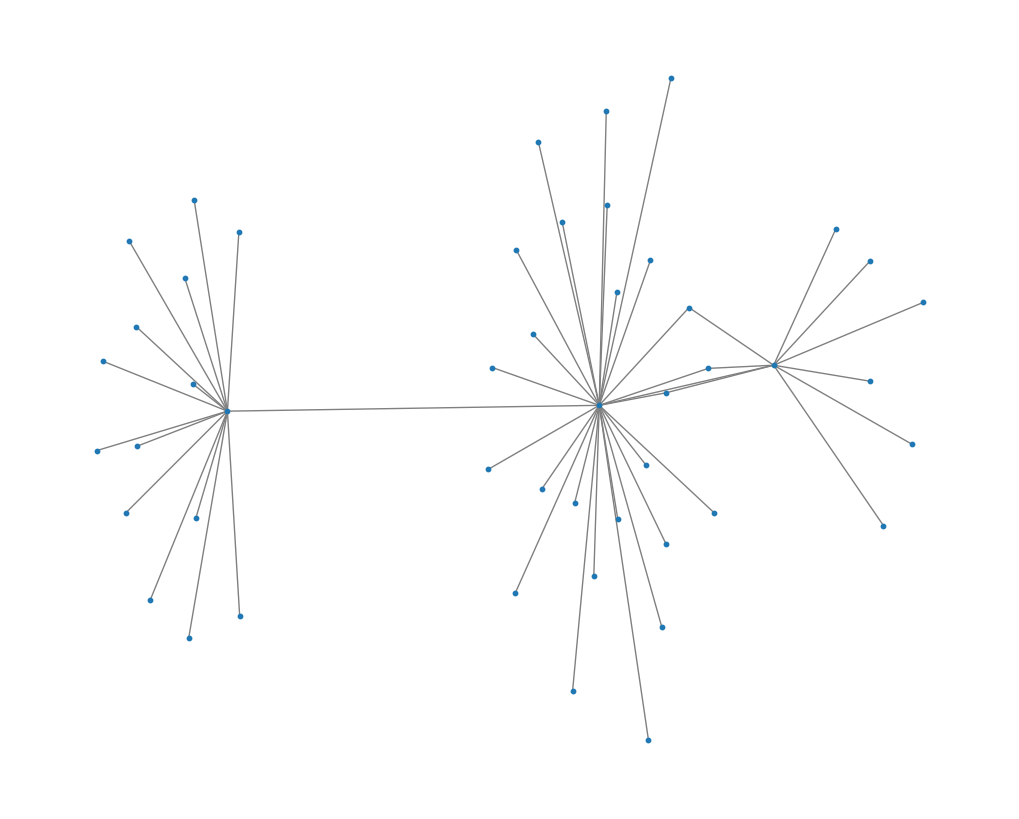

In [ ]:
import matplotlib.pyplot as plt

# Draw a small part of the graph (first 50 edges for clarity)
plt.figure(figsize=(10, 8))
subgraph = G.edge_subgraph(list(G.edges())[:50])  # Subgraph with first 50 edges
nx.draw(subgraph, with_labels=False, node_size=10, edge_color="gray")
plt.show()

**This first visualization is just a structural overview to see how the proteins are connected.
The output we got is fine for an initial check**

protein-protein interaction network is forming a hub-and-spoke structure, where a few proteins (nodes) have many connections (edges), while most others have fewer links.

Interpretation:
The highly connected nodes are likely key hub proteins in the Mycobacterium tuberculosis (Mtb) interactome.
The sparsely connected nodes represent proteins with fewer known interactions.

Step 1: Graph Embeddings (Node Representations) Goal: Convert proteins into numerical representations for analysis.

In [ ]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


Computing transition probabilities:   0%|          | 0/2464 [00:00<?, ?it/s]

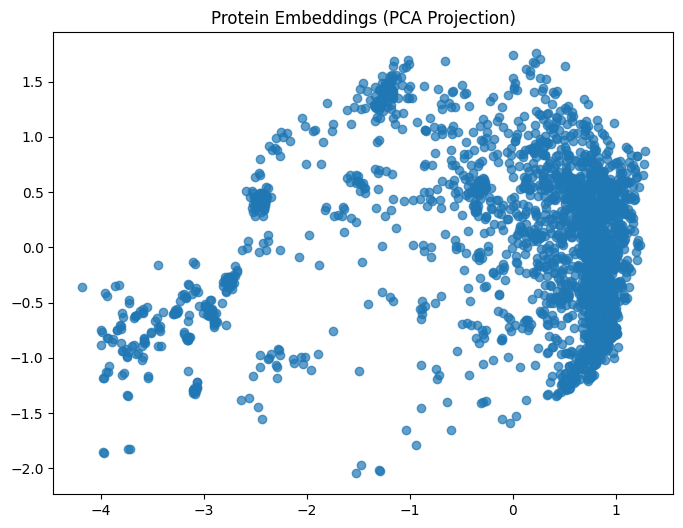

In [ ]:
from node2vec import Node2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Train Node2Vec model
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get embeddings
embeddings = {node: model.wv[node] for node in G.nodes()}

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(list(embeddings.values()))

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], alpha=0.7)
plt.title("Protein Embeddings (PCA Projection)")
plt.show()

generate a t-SNE visualization to see if it reveals clearer clusters.

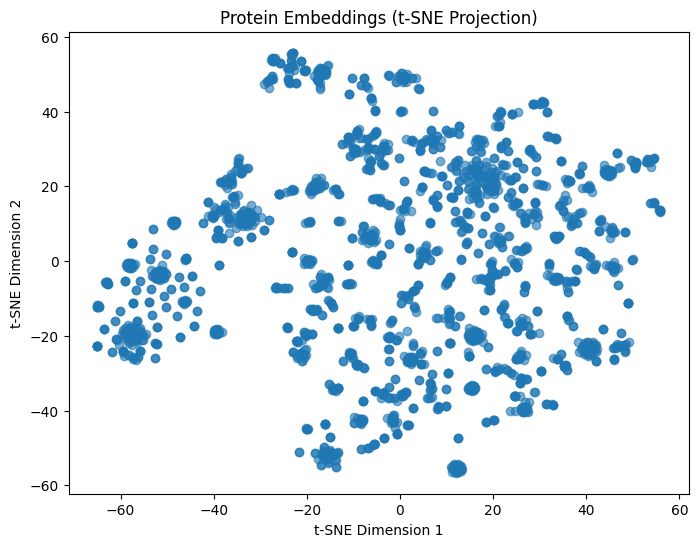

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert your embeddings to a NumPy array if not already
import numpy as np
embeddings_array = np.array(list(embeddings.values()))  # Assuming embeddings is a dictionary {node: embedding}

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_array)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.6)
plt.title("Protein Embeddings (t-SNE Projection)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

Check if embeddings are created!

In [ ]:
# Print first 5 nodes and their embeddings
for node, vector in list(embeddings.items())[:5]:
    print(f"Node: {node}, Embedding: {vector}")

Node: 83332.Rv0001, Embedding: [ 0.2856902   0.24316047  0.29382437 -0.167625    0.9109466  -0.42198157
  0.18620123  0.67497426  0.9151632  -0.15518314  0.44340283  0.21876733
 -0.22800958  0.6028947  -0.22464228 -0.10054363  0.07238454 -0.28575346
  0.11825746 -0.61692494  0.50304896  0.2399796  -0.02099774 -0.4916358
  0.07604558 -0.66383344  0.4712973  -0.22765684 -0.15793496  0.49506816
 -0.14949682  0.0152813   0.02925053 -0.3417759   0.4657647   0.33566847
  0.13652545  0.37424004 -0.32376808  0.08744422 -0.18569043 -0.01075111
 -0.47411653  0.1657313  -0.08299185 -0.04523253 -0.1306675   0.80541414
 -0.01568917  0.71228933 -0.2848591   0.52004063  0.10848562  0.44602886
  0.076187   -0.37747258 -0.48036215 -0.10882761 -0.45733917  0.2259784
  0.03795983  0.4297718   0.06937848  0.20202063]
Node: 83332.Rv2343c, Embedding: [ 0.12925926  0.6927544   0.17114398  0.17973903  0.6808688  -0.74088573
 -0.08491754  1.0309999   0.51166064 -0.19200674  0.4790316   0.39131045
  0.36554408 

In [ ]:
import pandas as pd

# Extract protein IDs (keys) and embedding vectors (values)
protein_ids = list(embeddings.keys())
embedding_vectors = list(embeddings.values())

# Convert to DataFrame
df = pd.DataFrame(embedding_vectors)
df.insert(0, "Protein_ID", protein_ids)  # Insert Protein IDs as the first column

# Save to CSV
df.to_csv("protein_embeddings.csv", index=False)

print("Embeddings saved to protein_embeddings.csv!")


Embeddings saved to protein_embeddings.csv!


shape of embeddings

In [ ]:
import numpy as np
embeddings_array = np.array(list(embeddings.values()))
print("Embedding Shape:", embeddings_array.shape)

Embedding Shape: (2464, 64)


Check if similar proteins have close embeddings using cosine similarity:
If similarity values are meaningful (e.g., between 0 and 1), embeddings are valid.
If it's always 0, embeddings might be faulty.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity between first two proteins
similarity = cosine_similarity([embeddings_array[0]], [embeddings_array[1]])
print("Similarity between first two proteins:", similarity[0][0])

Similarity between first two proteins: 0.7499391


Now, we need to:

Compare embeddings using cosine similarity.
Create a similarity matrix where each row represents a protein and each column represents how similar it is to other proteins.
Store the similarity scores for analysis.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the saved embeddings
df = pd.read_csv("protein_embeddings.csv")

# Extract the embeddings (excluding the Protein_ID column)
embedding_vectors = df.iloc[:, 1:].values  # Convert to NumPy array

# Compute cosine similarity
similarity_matrix = cosine_similarity(embedding_vectors)

# Convert to DataFrame with Protein IDs
similarity_df = pd.DataFrame(similarity_matrix, index=df["Protein_ID"], columns=df["Protein_ID"])

# Save similarity matrix
similarity_df.to_csv("protein_similarity_matrix.csv")

print("Similarity matrix saved to protein_similarity_matrix.csv!")


Similarity matrix saved to protein_similarity_matrix.csv!


In [ ]:
from google.colab import files
files.download("/content/protein_embeddings.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Since our end goal is to compute similarities between proteins and later use this data for network analysis and machine learning, the best choice is saving embeddings in a NumPy .npy file.

In [ ]:
import numpy as np

# Convert embeddings to NumPy array
embedding_matrix = np.array(list(embeddings.values()))

# Save to .npy file
np.save("protein_embeddings.npy", embedding_matrix)

# Save protein IDs separately
with open("protein_ids.txt", "w") as f:
    for protein_id in embeddings.keys():
        f.write(protein_id + "\n")

In [ ]:
import pandas as pd

# Load the embeddings from CSV
df = pd.read_csv("protein_embeddings.csv")  # Change the filename if needed

# Extract protein IDs and embeddings
protein_ids = df.iloc[:, 0].tolist()  # First column contains protein IDs
embeddings = df.iloc[:, 1:].values  # Remaining columns contain embeddings

print("Loaded", len(protein_ids), "proteins with embeddings of shape:", embeddings.shape)


Loaded 2464 proteins with embeddings of shape: (2464, 64)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute cosine similarity
similarity_matrix = cosine_similarity(embeddings)

# Convert to a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=protein_ids, columns=protein_ids)

# Save the similarity matrix
similarity_df.to_csv("protein_similarity.csv")

print("Similarity matrix saved! Shape:", similarity_df.shape)


Similarity matrix saved! Shape: (2464, 2464)


Now we have the similarity matrix, which means we can start analyzing the relationships between proteins.

Loads the similarity matrix and protein IDs
Extracts pairs with similarity above 0.7
Saves the strong interactions in a CSV file

In [ ]:
import numpy as np
import pandas as pd

# Load similarity matrix from CSV
similarity_matrix = pd.read_csv("protein_similarity_matrix.csv", index_col=0).values  # Convert to NumPy array

# Load protein IDs
with open("protein_ids.txt", "r") as f:
    protein_ids = [line.strip() for line in f]

# Set similarity threshold
threshold = 0.7  # Adjust if needed

# Extract pairs with similarity above the threshold
edges = []
for i in range(len(protein_ids)):
    for j in range(i + 1, len(protein_ids)):  # Avoid duplicate pairs
        if similarity_matrix[i, j] >= threshold:
            edges.append((protein_ids[i], protein_ids[j], similarity_matrix[i, j]))

# Convert to DataFrame
edge_df = pd.DataFrame(edges, columns=["Protein_1", "Protein_2", "Similarity"])

# Save to CSV
edge_df.to_csv("protein_interactions.csv", index=False)
print(f"Extracted {len(edges)} strong interactions and saved to 'protein_interactions.csv'.")

Extracted 46878 strong interactions and saved to 'protein_interactions.csv'.


Now that we have 46878 strong protein-protein interactions, the next step is to build a Knowledge Graph (KG) using NetworkX.

In [ ]:
import networkx as nx
import pandas as pd

# Load extracted interactions
edge_df = pd.read_csv("protein_interactions.csv")

# Create a graph
G = nx.Graph()

# Add edges from the DataFrame
for _, row in edge_df.iterrows():
    G.add_edge(row["Protein_1"], row["Protein_2"], weight=row["Similarity"])

# Basic graph info
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Save the graph
nx.write_gml(G, "protein_interaction_graph.gml")
print("Graph saved as 'protein_interaction_graph.gml'.")


Graph created with 2458 nodes and 46878 edges.
Graph saved as 'protein_interaction_graph.gml'.


visualising

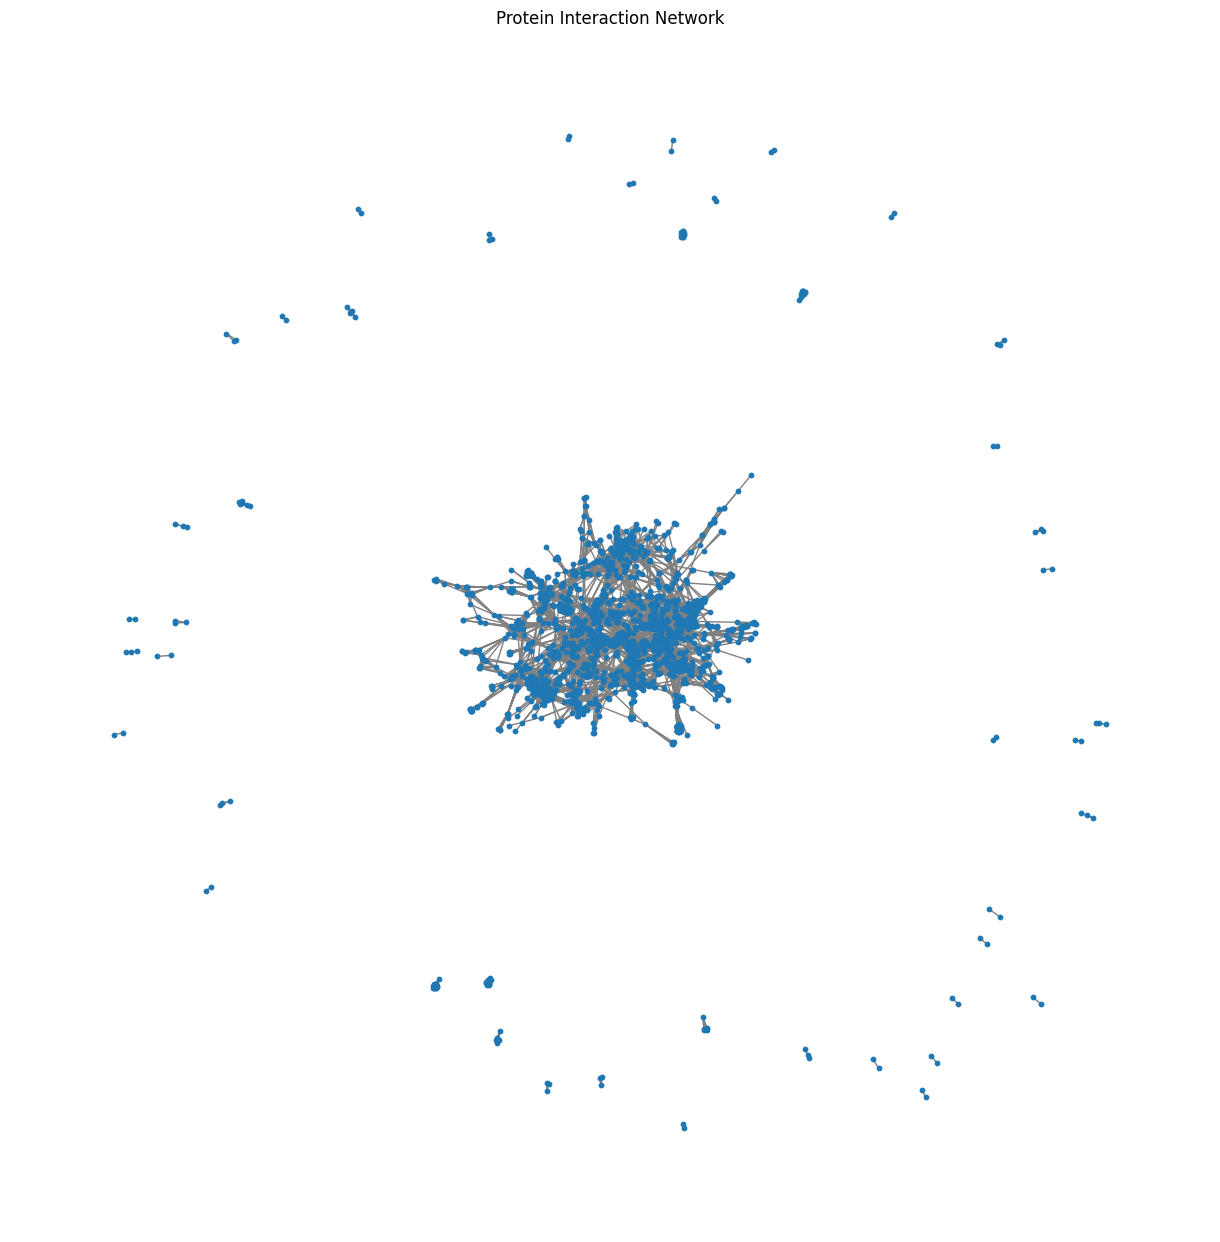

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the graph
G = nx.read_gml("protein_interaction_graph.gml")

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=False, node_size=10, edge_color="gray")
plt.title("Protein Interaction Network")
plt.show()


Dense central cluster – There’s a highly interconnected core, which likely contains hub proteins that interact with many others.

Sparse peripheral nodes – Some proteins have very few interactions, possibly orphan proteins or weakly connected ones.

Possible modular structure – The outer nodes form small groups, which could be functional clusters (protein complexes or subsystems).

TOP 10 HUBS

In [ ]:
import networkx as nx

G = nx.read_gml("protein_interaction_graph.gml")

# Degree centrality (importance based on connections)
degree_centrality = nx.degree_centrality(G)

# Find top 10 hubs
top_hubs = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 hub proteins:", top_hubs)

Top 10 hub proteins: [('83332.Rv1197', 0.07895807895807895), ('83332.Rv3881c', 0.07651607651607652), ('83332.Rv3619c', 0.0757020757020757), ('83332.Rv1196', 0.0757020757020757), ('83332.Rv0288', 0.07488807488807489), ('83332.Rv3879c', 0.05942205942205942), ('83332.Rv2058c', 0.05860805860805861), ('83332.Rv0105c', 0.05860805860805861), ('83332.Rv3442c', 0.05860805860805861), ('83332.Rv3870', 0.0582010582010582)]


COMMUNITY DETECTION

In [ ]:
from networkx.algorithms import community

# Community detection using modularity optimization
communities = community.greedy_modularity_communities(G)

# Print top 5 largest communities
for i, c in enumerate(communities[:5]):
    print(f"Community {i+1}: {list(c)[:10]} ... ({len(c)} proteins)")

Community 1: ['83332.Rv2780', '83332.Rv3711c', '83332.Rv2837c', '83332.Rv1814', '83332.Rv2321c', '83332.Rv3526', '83332.Rv1445c', '83332.Rv0447c', '83332.Rv1381', '83332.Rv2955c'] ... (717 proteins)
Community 2: ['83332.Rv3790', '83332.Rv3492c', '83332.Rv3473c', '83332.Rv2618', '83332.Rv3177', '83332.Rv2246', '83332.Rv3563', '83332.Rv1661', '83332.Rv2875', '83332.Rv3152'] ... (434 proteins)
Community 3: ['83332.Rv1781c', '83332.Rv0844c', '83332.Rv3583c', '83332.Rv3495c', '83332.Rv1407', '83332.Rv0073', '83332.Rv3736', '83332.Rv2483c', '83332.Rv3664c', '83332.Rv0929'] ... (239 proteins)
Community 4: ['83332.Rv1840c', '83332.Rv2839c', '83332.Rv3516', '83332.Rv1070c', '83332.Rv2790c', '83332.Rv2587c', '83332.Rv1475c', '83332.Rv1440', '83332.Rv3039c', '83332.Rv2838c'] ... (238 proteins)
Community 5: ['83332.Rv1450c', '83332.Rv1068c', '83332.Rv3511', '83332.Rv1110', '83332.Rv3909', '83332.Rv3902c', '83332.Rv3284', '83332.Rv3876', '83332.Rv2922c', '83332.Rv1709'] ... (188 proteins)


In the Food KG, entities and relationships were structured as triples.
We need to extract interactions as (Protein1, Relationship, Protein2) format.
Example Triple: ("83332.Rv0001", "interacts_with", "83332.Rv2343c")

In [ ]:
import pandas as pd

# Load the interaction graph
edges = list(G.edges())

# Convert to triples format
triples = [(u, "interacts_with", v) for u, v in edges]

# Save as CSV for KG integration
df = pd.DataFrame(triples, columns=["Protein1", "Relation", "Protein2"])
df.to_csv("protein_kg_triples.csv", index=False)

print("Triples saved!")

Triples saved!


In [ ]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 4.6 MB/s eta 0:00:00


In [ ]:
from neo4j import GraphDatabase

# Use your actual username and password
URI = "neo4j+s://c4c994d1.databases.neo4j.io"
AUTH = ("neo4j", "TVj6pTrIJqzBHvaePBudEAzkerxutV_1G-z3G7gZf_U")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

print("Connected successfully!")

Connected successfully!


upload your triples into Neo4j.

In [ ]:
import pandas as pd

# Read the file as plain text to inspect its format
with open("protein_kg_triples.csv", "r") as f:
    raw_content = f.readlines()

# Print the first few lines
for i, line in enumerate(raw_content[:5]):
    print(f"Line {i+1}: {line}")


Line 1: Protein1,Relation,Protein2

Line 2: 83332.Rv0001,interacts_with,83332.Rv2343c

Line 3: 83332.Rv0001,interacts_with,83332.Rv3427c

Line 4: 83332.Rv0001,interacts_with,83332.Rv3923c

Line 5: 83332.Rv0001,interacts_with,83332.Rv2944



Load Triples into Neo4j and verify data in neo4j cypher !

In [ ]:
from neo4j import GraphDatabase
import pandas as pd

# Connect to Neo4j
URI = "neo4j+s://c4c994d1.databases.neo4j.io"
AUTH = ("neo4j", "TVj6pTrIJqzBHvaePBudEAzkerxutV_1G-z3G7gZf_U")

# Read triples
triples_df = pd.read_csv("protein_kg_triples.csv")

# Print column names to verify
print("Columns in the CSV file:", triples_df.columns)

# Filter out rows with NaN or null values in 'Protein1' or 'Protein2' columns
triples_df = triples_df.dropna(subset=['Protein1', 'Protein2'])

# Function to insert triples into Neo4j
def insert_triples_batch(tx, batch):
    query = """
    UNWIND $batch AS row
    MERGE (s:Protein {id: row.Protein1})
    MERGE (o:Protein {id: row.Protein2})
    MERGE (s)-[:INTERACTS_WITH]->(o)
    """
    tx.run(query, batch=batch)

# Insert data in BATCHES of 1000 rows at a time
BATCH_SIZE = 1000

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session() as session:
        for i in range(0, len(triples_df), BATCH_SIZE):
            batch = triples_df.iloc[i:i+BATCH_SIZE].to_dict(orient="records")
            session.execute_write(insert_triples_batch, batch)
            print(f"Inserted {i + len(batch)} / {len(triples_df)} rows...")

print("All triples inserted successfully!")


Columns in the CSV file: Index(['Protein1', 'Relation', 'Protein2'], dtype='object')
Inserted 1000 / 46878 rows...
Inserted 2000 / 46878 rows...
Inserted 3000 / 46878 rows...
Inserted 4000 / 46878 rows...
Inserted 5000 / 46878 rows...
Inserted 6000 / 46878 rows...
Inserted 7000 / 46878 rows...
Inserted 8000 / 46878 rows...
Inserted 9000 / 46878 rows...
Inserted 10000 / 46878 rows...
Inserted 11000 / 46878 rows...
Inserted 12000 / 46878 rows...
Inserted 13000 / 46878 rows...
Inserted 14000 / 46878 rows...
Inserted 15000 / 46878 rows...
Inserted 16000 / 46878 rows...
Inserted 17000 / 46878 rows...
Inserted 18000 / 46878 rows...
Inserted 19000 / 46878 rows...
Inserted 20000 / 46878 rows...
Inserted 21000 / 46878 rows...
Inserted 22000 / 46878 rows...
Inserted 23000 / 46878 rows...
Inserted 24000 / 46878 rows...
Inserted 25000 / 46878 rows...
Inserted 26000 / 46878 rows...
Inserted 27000 / 46878 rows...
Inserted 28000 / 46878 rows...
Inserted 29000 / 46878 rows...
Inserted 30000 / 46878 ro

In [ ]:
# Install NetworkX and py2neo (for interacting with Neo4j)
!pip install networkx py2neo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 7.9 MB/s eta 0:00:00


In [ ]:
from neo4j import GraphDatabase
import networkx as nx

# Connect to your Neo4j database
uri = "neo4j+s://c4c994d1.databases.neo4j.io"
auth = ("neo4j", "TVj6pTrIJqzBHvaePBudEAzkerxutV_1G-z3G7gZf_U")
driver = GraphDatabase.driver(uri, auth=auth)

# Query to fetch Protein interactions
query = """
MATCH (p1:Protein)-[:INTERACTS_WITH]->(p2:Protein)
RETURN p1.id AS Protein1, p2.id AS Protein2
"""

# Execute the query and create a NetworkX graph
G = nx.Graph()

with driver.session() as session:
    result = session.run(query)
    for record in result:
        # Add edges between proteins
        G.add_edge(record["Protein1"], record["Protein2"])

print(f"Graph created with {len(G.nodes())} nodes and {len(G.edges())} edges.")

Graph created with 2458 nodes and 46878 edges.


Community Detection with NetworkX
Louvain Community Detection Algorithm

In [ ]:
# Install the community library for Louvain
!pip install python-louvain

apply Louvain community detection

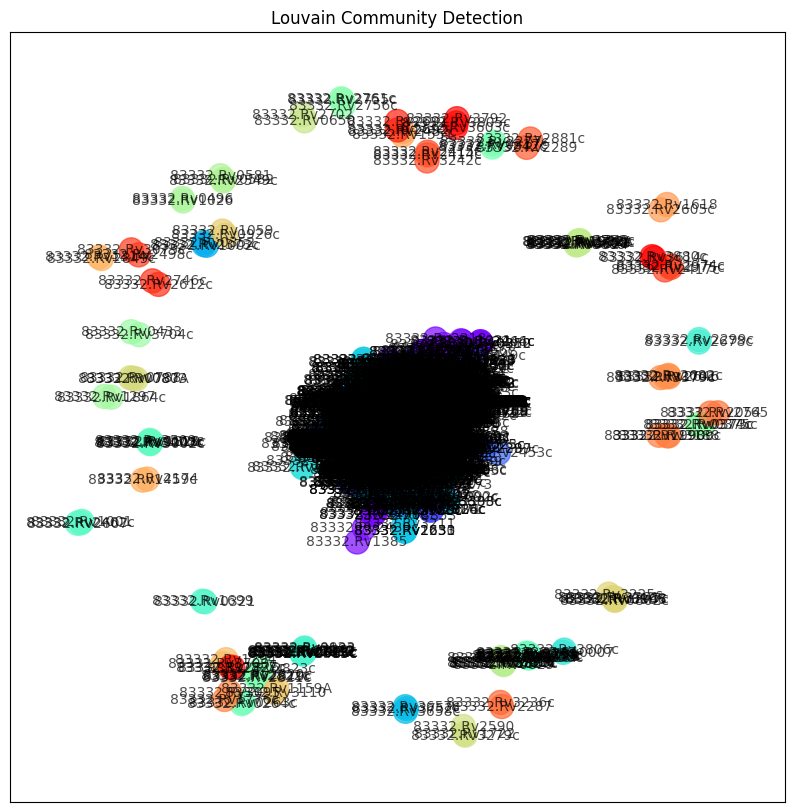

Communities detected:
Community 0: ['83332.Rv0001', '83332.Rv2343c', '83332.Rv3427c', '83332.Rv3923c', '83332.Rv2944']...
Community 1: ['83332.Rv0005', '83332.Rv0006', '83332.Rv3855', '83332.Rv0340', '83332.Rv3247c']...
Community 2: ['83332.Rv0274', '83332.Rv2641', '83332.Rv1322A', '83332.Rv3568c', '83332.Rv0383c']...
Community 3: ['83332.Rv1603', '83332.Rv2535c', '83332.Rv2089c', '83332.Rv1955', '83332.Rv3411c']...
Community 4: ['83332.Rv1328', '83332.Rv1316c', '83332.Rv0639', '83332.Rv2841c', '83332.Rv3137']...
Community 5: ['83332.Rv2903c', '83332.Rv1819c', '83332.Rv1684', '83332.Rv1218c', '83332.Rv1687c']...
Community 6: ['83332.Rv3282', '83332.Rv3917c', '83332.Rv2647', '83332.Rv1203c', '83332.Rv1496']...
Community 7: ['83332.Rv1752', '83332.Rv0853c', '83332.Rv1606', '83332.Rv0032', '83332.Rv1569']...
Community 8: ['83332.Rv0700', '83332.Rv0079', '83332.Rv0709', '83332.Rv0721', '83332.Rv0719']...
Community 9: ['83332.Rv1461', '83332.Rv1698', '83332.Rv3902c', '83332.Rv0888', '83332.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain

# Apply Louvain community detection
partition = community_louvain.best_partition(G)

# Visualize communities
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))

# Draw nodes with different colors for each community
cmap = plt.cm.rainbow
colors = [cmap(partition[node] / max(partition.values())) for node in G.nodes()]

# Use draw_networkx instead of draw_networkx_nodes for both nodes and labels
nx.draw_networkx(G, pos, node_color=colors, with_labels=True, node_size=300, font_size=10, alpha=0.7)

plt.title("Louvain Community Detection")
plt.show()

# You can also print out the communities
communities = {}
for node, comm in partition.items():
    if comm not in communities:
        communities[comm] = []
    communities[comm].append(node)

print("Communities detected:")
for comm, members in communities.items():
    print(f"Community {comm}: {members[:5]}...")  # Print first 5 members of each community

In [ ]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 5.9 MB/s eta 0:00:00


The dots in the output are simply indicating that the list of proteins or entities within the community is truncated for readability. It doesn't mean that some proteins were missing from the list; it's just a representation of a long list that's been shortened for display purposes.

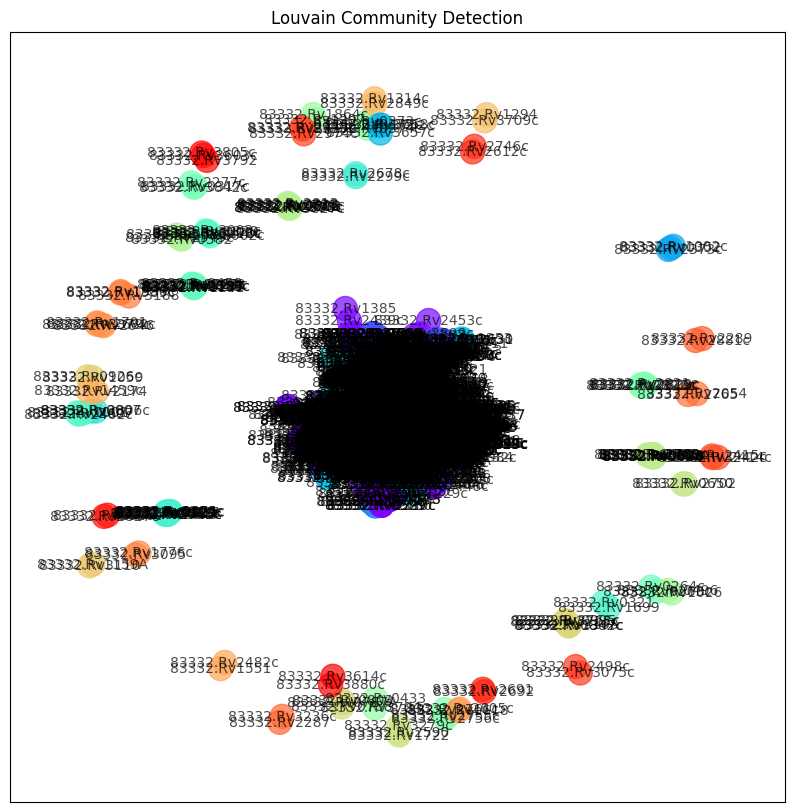

Communities detected:
Community 0: ['83332.Rv0001', '83332.Rv2343c', '83332.Rv3427c', '83332.Rv3923c', '83332.Rv2944']...
Community 1: ['83332.Rv0005', '83332.Rv0006', '83332.Rv3855', '83332.Rv0340', '83332.Rv3247c']...
Community 2: ['83332.Rv0274', '83332.Rv2641', '83332.Rv1322A', '83332.Rv3568c', '83332.Rv0383c']...
Community 3: ['83332.Rv1603', '83332.Rv2535c', '83332.Rv2089c', '83332.Rv1955', '83332.Rv3411c']...
Community 4: ['83332.Rv1328', '83332.Rv1316c', '83332.Rv0639', '83332.Rv2841c', '83332.Rv3137']...
Community 5: ['83332.Rv2903c', '83332.Rv1819c', '83332.Rv1684', '83332.Rv1218c', '83332.Rv1687c']...
Community 6: ['83332.Rv3282', '83332.Rv3917c', '83332.Rv2647', '83332.Rv1203c', '83332.Rv1496']...
Community 7: ['83332.Rv1752', '83332.Rv0853c', '83332.Rv1606', '83332.Rv0032', '83332.Rv1569']...
Community 8: ['83332.Rv0700', '83332.Rv0079', '83332.Rv0709', '83332.Rv0721', '83332.Rv0719']...
Community 9: ['83332.Rv1315', '83332.Rv3717', '83332.Rv3915', '83332.Rv0950c', '83332.

In [ ]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain

# Neo4j connection details
URI = "neo4j+s://c4c994d1.databases.neo4j.io"
AUTH = ("neo4j", "TVj6pTrIJqzBHvaePBudEAzkerxutV_1G-z3G7gZf_U")

# Connect to Neo4j
driver = GraphDatabase.driver(URI, auth=AUTH)

# Function to fetch interactions from Neo4j and build a NetworkX graph
def fetch_interactions(driver):
    query = """
    MATCH (p1:Protein)-[:INTERACTS_WITH]->(p2:Protein)
    RETURN p1.id AS Protein1, p2.id AS Protein2
    """
    with driver.session() as session:
        result = session.run(query)
        interactions = [(record["Protein1"], record["Protein2"]) for record in result]

    return interactions

# Fetch interactions from Neo4j
interactions = fetch_interactions(driver)

# Step 1: Create the NetworkX graph
G = nx.Graph()

# Step 2: Add nodes and edges based on the fetched data
G.add_edges_from(interactions)

# Step 3: Apply Louvain community detection
partition = community_louvain.best_partition(G)

# Step 4: Visualize the communities
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))

# Draw nodes with different colors for each community
cmap = plt.cm.rainbow
colors = [cmap(partition[node] / max(partition.values())) for node in G.nodes()]

# Draw the graph
nx.draw_networkx(G, pos, node_color=colors, with_labels=True, node_size=300, font_size=10, alpha=0.7)

plt.title("Louvain Community Detection")
plt.show()

# Step 5: Print out the detected communities
communities = {}
for node, comm in partition.items():
    if comm not in communities:
        communities[comm] = []
    communities[comm].append(node)

# Print the first 5 members of each community
print("Communities detected:")
for comm, members in communities.items():
    print(f"Community {comm}: {members[:5]}...")  # Print first 5 members of each community

In [ ]:
import pandas as pd

# Read the data into a DataFrame
data = pd.read_csv("/content/protein_kg_triples.csv", delimiter="\t")

# Print the column names to check for any discrepancies
print("Column names:", data.columns)

# Clean the column names (strip any leading/trailing spaces)
data.columns = data.columns.str.strip()

# Verify the columns again after cleaning
print("Cleaned column names:", data.columns)

Column names: Index(['Protein1,Relation,Protein2'], dtype='object')
Cleaned column names: Index(['Protein1,Relation,Protein2'], dtype='object')


In [ ]:
import pandas as pd

# Read the data with the correct delimiter (comma)
data = pd.read_csv("/content/protein_kg_triples.csv", delimiter=",")

# Print the column names to verify
print("Column names:", data.columns)

# Clean the column names (strip any leading/trailing spaces)
data.columns = data.columns.str.strip()

# Check the first few rows of the data to ensure it is now correctly formatted
print(data.head())

Column names: Index(['Protein1', 'Relation', 'Protein2'], dtype='object')
       Protein1        Relation       Protein2
0  83332.Rv0001  interacts_with  83332.Rv2343c
1  83332.Rv0001  interacts_with  83332.Rv3427c
2  83332.Rv0001  interacts_with  83332.Rv3923c
3  83332.Rv0001  interacts_with   83332.Rv2944
4  83332.Rv0001  interacts_with   83332.Rv0113


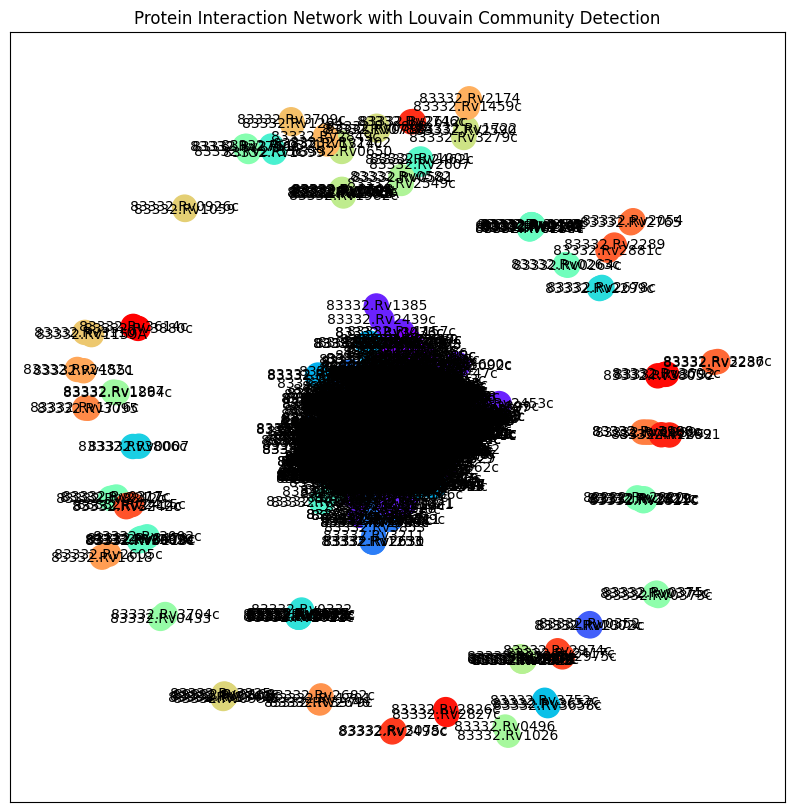

Communities detected:
Community 0: ['83332.Rv0001', '83332.Rv2343c', '83332.Rv3427c', '83332.Rv3923c', '83332.Rv2944']...
Community 1: ['83332.Rv0639', '83332.Rv2841c', '83332.Rv3137', '83332.Rv2533c', '83332.Rv1604']...
Community 2: ['83332.Rv0700', '83332.Rv0079', '83332.Rv3296', '83332.Rv0704', '83332.Rv0705']...
Community 3: ['83332.Rv0005', '83332.Rv0006', '83332.Rv3855', '83332.Rv1698', '83332.Rv3902c']...
Community 4: ['83332.Rv3213c', '83332.Rv1708', '83332.Rv3918c', '83332.Rv2748c', '83332.Rv2450c']...
Community 5: ['83332.Rv3917c', '83332.Rv2647', '83332.Rv1203c', '83332.Rv1496', '83332.Rv2163c']...
Community 6: ['83332.Rv1195', '83332.Rv3477', '83332.Rv3873', '83332.Rv2608', '83332.Rv3872']...
Community 7: ['83332.Rv1796', '83332.Rv3449', '83332.Rv0291', '83332.Rv3886c', '83332.Rv2133c']...
Community 8: ['83332.Rv2373c', '83332.Rv0352', '83332.Rv1002c']...
Community 9: ['83332.Rv2903c', '83332.Rv1819c', '83332.Rv1348', '83332.Rv1218c', '83332.Rv1687c']...
Community 10: ['833

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import community as community_louvain

# Load the data
data = pd.read_csv("/content/protein_kg_triples.csv")

# Create an empty graph
G = nx.Graph()

# Add edges from the dataframe
for _, row in data.iterrows():
    G.add_edge(row['Protein1'], row['Protein2'])

# Apply Louvain community detection
partition = community_louvain.best_partition(G)

# Visualize communities
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))

# Draw nodes with different colors for each community
cmap = plt.cm.rainbow
colors = [cmap(partition[node] / max(partition.values())) for node in G.nodes()]

# Visualize the graph
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Protein Interaction Network with Louvain Community Detection")
plt.show()

# Print communities detected
communities = {}
for node, comm in partition.items():
    if comm not in communities:
        communities[comm] = []
    communities[comm].append(node)

print("Communities detected:")
for comm, members in communities.items():
    print(f"Community {comm}: {members[:5]}...")  # Show first 5 members of each community

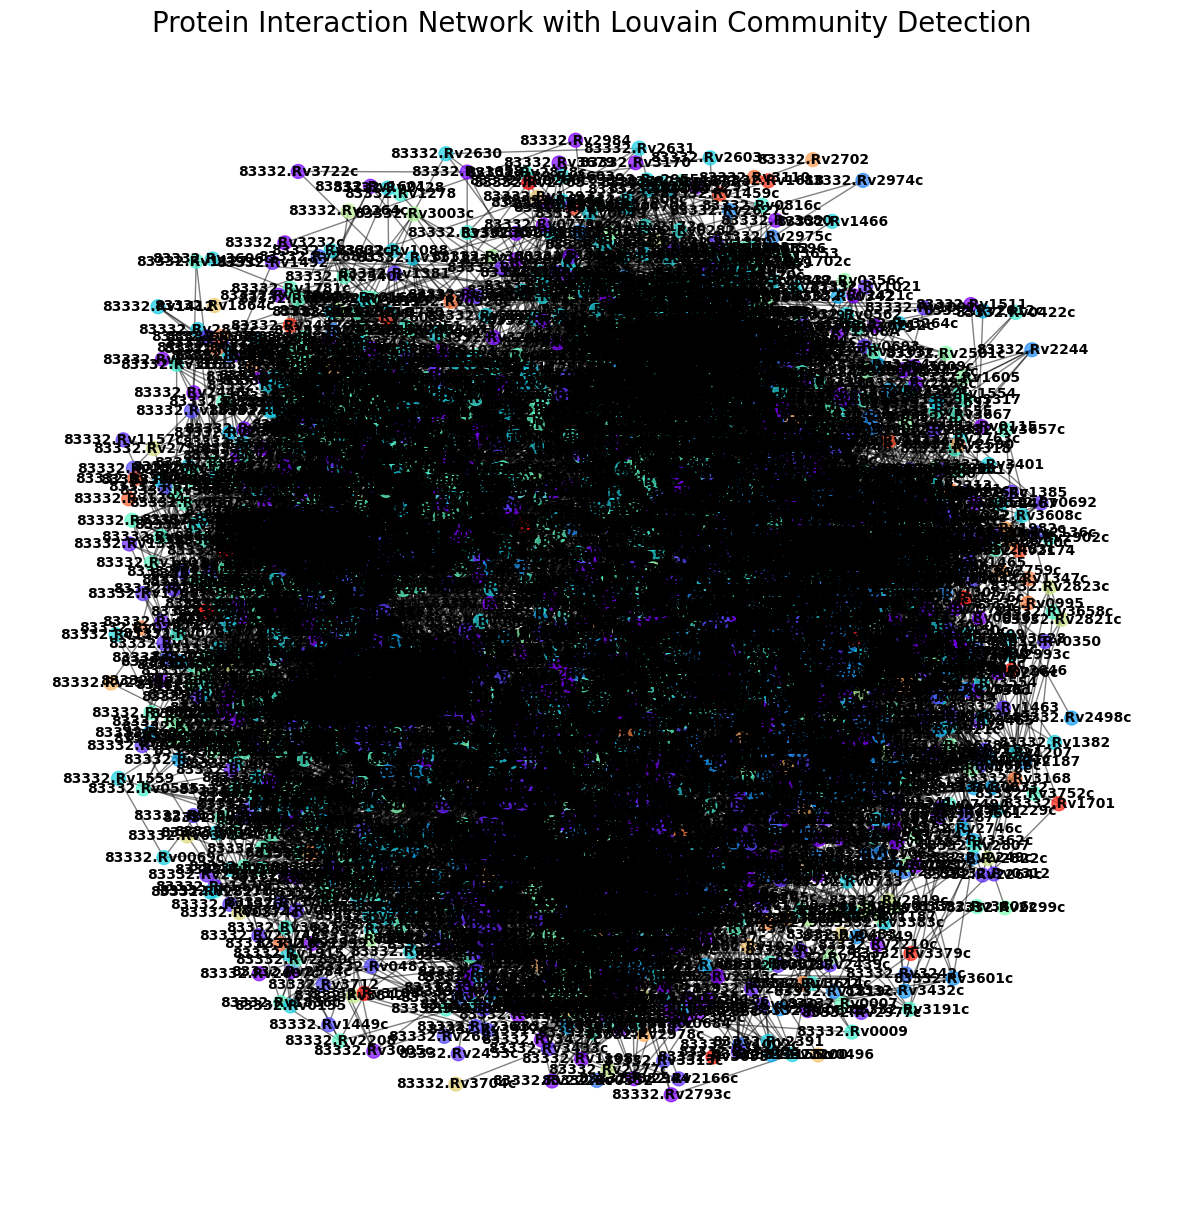

Communities detected:
Community 0: ['83332.Rv0001', '83332.Rv2343c', '83332.Rv3427c', '83332.Rv3923c', '83332.Rv2944']...
Community 19: ['83332.Rv3264c', '83332.Rv0383c', '83332.Rv0274', '83332.Rv2641', '83332.Rv1322A']...
Community 28: ['83332.Rv0639', '83332.Rv2841c', '83332.Rv3137', '83332.Rv2533c', '83332.Rv1604']...
Community 3: ['83332.Rv0700', '83332.Rv0079', '83332.Rv3296', '83332.Rv0704', '83332.Rv0705']...
Community 4: ['83332.Rv0005', '83332.Rv0006', '83332.Rv3855', '83332.Rv1698', '83332.Rv3902c']...
Community 5: ['83332.Rv3213c', '83332.Rv1708', '83332.Rv3918c', '83332.Rv2748c', '83332.Rv2450c']...
Community 6: ['83332.Rv3917c', '83332.Rv2647', '83332.Rv1203c', '83332.Rv1496', '83332.Rv2163c']...
Community 7: ['83332.Rv1195', '83332.Rv3477', '83332.Rv3873', '83332.Rv2608', '83332.Rv3872']...
Community 25: ['83332.Rv1796', '83332.Rv3449', '83332.Rv0291', '83332.Rv3886c', '83332.Rv1277']...
Community 10: ['83332.Rv2373c', '83332.Rv0352', '83332.Rv1002c']...
Community 12: ['8

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import community as community_louvain

# Load the data
data = pd.read_csv("/content/protein_kg_triples.csv")

# Create an empty graph
G = nx.Graph()

# Add edges from the dataframe
for _, row in data.iterrows():
    G.add_edge(row['Protein1'], row['Protein2'])

# Apply Louvain community detection
partition = community_louvain.best_partition(G)

# Choose a layout to better position nodes
pos = nx.spring_layout(G, k=0.15, iterations=20)  # Adjust layout parameters

# Create the plot
plt.figure(figsize=(15, 15))

# Draw nodes with different colors for each community
cmap = plt.cm.rainbow
colors = [cmap(partition[node] / max(partition.values())) for node in G.nodes()]

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=colors, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5, width=1.0)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black", font_weight="bold")

# Title
plt.title("Protein Interaction Network with Louvain Community Detection", fontsize=20)

# Show plot
plt.axis("off")
plt.show()

# Print communities detected
communities = {}
for node, comm in partition.items():
    if comm not in communities:
        communities[comm] = []
    communities[comm].append(node)

print("Communities detected:")
for comm, members in communities.items():
    print(f"Community {comm}: {members[:5]}...")  # Show first 5 members of each community

In [ ]:
pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from itertools import combinations

# Load degrees CSV
df = pd.read_csv("/content/Node degrees.csv")

# Create dictionary for quick lookup
degree_dict = dict(zip(df["Protein"], df["Degree"]))

# Compute Preferential Attachment Scores
scores = [
    (p1, p2, degree_dict[p1] * degree_dict[p2])
    for p1, p2 in combinations(degree_dict.keys(), 2)
]

# Save results
output_file = "preferential_attachment.csv"
pd.DataFrame(scores, columns=["Protein1", "Protein2", "PreferentialAttachmentScore"]).to_csv(output_file, index=False)

print(f"Preferential Attachment scores saved to {output_file}")

Preferential Attachment scores saved to preferential_attachment.csv


In [ ]:
import pandas as pd

# Load the large file
df = pd.read_csv("preferential_attachment.csv")

# Check the first few rows
print(df.head())

       Protein1       Protein2  PreferentialAttachmentScore
0  83332.Rv0001  83332.Rv2343c                          810
1  83332.Rv0001  83332.Rv3427c                         1080
2  83332.Rv0001  83332.Rv3923c                          450
3  83332.Rv0001   83332.Rv2944                          720
4  83332.Rv0001   83332.Rv0113                          540


In [ ]:
# Keep the top 50,000 highest Preferential Attachment Scores
df_top = df.nlargest(50000, "PreferentialAttachmentScore")

# Save the filtered data
df_top.to_csv("top_preferential_attachment.csv", index=False)

In [ ]:
import os

# Check file size in MB
file_size = os.path.getsize("top_preferential_attachment.csv") / (1024 * 1024)
print(f"New file size: {file_size:.2f} MB")

New file size: 1.58 MB


In [ ]:
pip install pandas

In [ ]:
import pandas as pd

# Load the Jaccard Similarity CSV
jaccard_df = pd.read_csv("/content/Jaccard similarity scores.csv")  # Replace with actual filename

# Sort by score in descending order (highest scores first)
jaccard_df = jaccard_df.sort_values(by="JaccardSimilarity", ascending=False)

# Select the top 10% of rows
top_10_percent = int(len(jaccard_df) * 0.10)  # Change to 0.20 for top 20%
filtered_jaccard = jaccard_df.head(top_10_percent)

# Save the filtered data
filtered_jaccard.to_csv("filtered_jaccard.csv", index=False)

print("Filtered Jaccard file saved as 'filtered_jaccard.csv'")

Filtered Jaccard file saved as 'filtered_jaccard.csv'


In [ ]:
# Load and filter Adamic-Adar
adamic_df = pd.read_csv("/content/Adamic Scores.csv")
adamic_df = adamic_df.sort_values(by="AdamicAdarScore", ascending=False)
filtered_adamic = adamic_df.head(top_10_percent)
filtered_adamic.to_csv("filtered_adamic.csv", index=False)

# Load and filter Preferential Attachment (optional)
pref_attach_df = pd.read_csv("/content/top_preferential_attachment.csv")
pref_attach_df = pref_attach_df.sort_values(by="PreferentialAttachmentScore", ascending=False)
filtered_pref_attach = pref_attach_df.head(top_10_percent)
filtered_pref_attach.to_csv("filtered_pref_attachment.csv", index=False)

print("Filtered Adamic-Adar and Preferential Attachment files saved!")

Filtered Adamic-Adar and Preferential Attachment files saved!
